# Create Australian monthly temperature anomaly animation over 1850-2005 using Celluloid

* read in data
* caculate global anormaly
* capture monthly average snapshot of each year
* save as a GIF image

This example uses Coupled Model Intercomparison Project (CMIP6) collections. For more information, please visit the [NCI data catalogue]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f5194_5909_8003_9216).

---

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP, animation, celluloid
- Create Date: 2020-Aug
---

This notebook is licenced under the [Creative Commons Attribution 4.0 International license](https://creativecommons.org/licenses/by/4.0/)

### Import Python libraries

In [1]:
from celluloid import Camera
from matplotlib import pyplot as plt
import numpy as np
import os
import xarray as xr

%matplotlib inline

### Define dataset of interest

Let's take a look at the Australian near-surface air temperature anomoly dataset from the CMIP6 CSIRO ACCESS_ESM_1.5 historical model.

In [2]:
### define data file of interest and open using xarray
path_CMIP6 = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/\
day/tas/gn/v20191115/*.nc'
tas_aus = xr.open_mfdataset(path_CMIP6,combine='by_coords').tas.sel(lat=slice(-50,-5), lon=slice(110,160))
tas_aus

<xarray.DataArray 'tas' (time: 60265, lat: 37, lon: 27)>
dask.array<getitem, shape=(60265, 37, 27), dtype=float32, chunksize=(18262, 37, 27), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -50.0 -48.75 -47.5 -46.25 ... -8.75 -7.5 -6.25 -5.0
  * lon      (lon) float64 110.6 112.5 114.4 116.2 ... 153.8 155.6 157.5 159.4
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:30:04Z altered by CMOR: Treated scalar dime...

Change the temperature units from K to C.

In [3]:
tas_aus = tas_aus-273.15
tas_aus.sel(lat=-45,lon=116,time='1850-01-01',method='nearest').values

array([10.923798], dtype=float32)

In [4]:
### open areacella dataset over area of interest:
file_area = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/\
r1i1p1f1/fx/areacella/gn/v20191115/areacella_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc')
area = file_area.areacella
aus_area = area.sel(lat=slice(-50,-5), lon=slice(110,160))
aus_area

<xarray.DataArray 'areacella' (lat: 37, lon: 27)>
array([[1.862140e+10, 1.862140e+10, 1.862140e+10, ..., 1.862140e+10,
        1.862140e+10, 1.862140e+10],
       [1.910109e+10, 1.910109e+10, 1.910109e+10, ..., 1.910109e+10,
        1.910109e+10, 1.910109e+10],
       [1.957169e+10, 1.957169e+10, 1.957169e+10, ..., 1.957169e+10,
        1.957169e+10, 1.957169e+10],
       ...,
       [2.872192e+10, 2.872192e+10, 2.872192e+10, ..., 2.872192e+10,
        2.872192e+10, 2.872192e+10],
       [2.879758e+10, 2.879758e+10, 2.879758e+10, ..., 2.879758e+10,
        2.879758e+10, 2.879758e+10],
       [2.885953e+10, 2.885953e+10, 2.885953e+10, ..., 2.885953e+10,
        2.885953e+10, 2.885953e+10]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -50.0 -48.75 -47.5 -46.25 ... -8.75 -7.5 -6.25 -5.0
  * lon      (lon) float64 110.6 112.5 114.4 116.2 ... 153.8 155.6 157.5 159.4
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Atmospheric Grid Variables
    comment:        For atmospheres with more than 1 mesh (e.g., staggered gr...
    units:          m2
    cell_methods:   area: sum
    history:        2019-11-15T17:53:04Z altered by CMOR: replaced missing va...

In [5]:
### Calculate the area weighted mean.
tas_aus_area = tas_aus*aus_area
tas_aus_wmean = tas_aus_area.sum(['lat','lon']) / (aus_area.sum())
tas_anom = tas_aus_wmean - tas_aus_wmean.mean()
tas_anom

<xarray.DataArray (time: 60265)>
dask.array<sub, shape=(60265,), dtype=float32, chunksize=(18262,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00

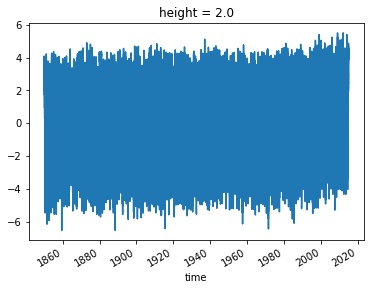

In [6]:
### plot time series of Near Surface Air Temperature
tas_anom.plot()

In [7]:
### Now create a monthly climatology for the period between 1850 to 2014.
tas_anom_aus_clim = tas_anom.sel(time=slice('1850-01','2014-12')).resample(time='M').mean(dim='time')
tas_anom_aus_clim

,Array,Chunk
Bytes,7.92 kB,4 B
Shape,"(1980,)","(1,)"
Count,7976 Tasks,1980 Chunks
Type,float32,numpy.ndarray


Define a function to plot up the monthly anomaly:

In [8]:
def plotting_ave(y):
   
    for i in range(len(y)//12):
        y2 = y[i*12+1:i*12+13]
        if i < len(y)//12-1:
            plt.plot(y2,color='black')
        if i == len(y)//12-1:
            plt.plot(y2,color='red')

Finally, let's create our animation:

In [ ]:
x = range(1,13)
y = tas_anom_aus_clim.values
fig = plt.figure()
ax = plt.subplot()
camera = Camera(fig)
month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct',
    'Nov','Dec']
    
print(len(y)//12)
for i in range(len(y)//12):
#for i in [1,2,3,4,5,6]:
    year = i+1849
    plotting_ave(y[:(i-1)*12+13])
    ax.text(5, 0, f'{year}')
    ax.set_xlabel('Month')  # Add an x-label to the axes.
    ax.set_ylabel('Near-Surface Air Temperature anomaly')  # Add a y-label to the axes.
    ax.set_ylim([-6,6])
    ax.set_title("Australian temperature anomaly")  # Add a title to the axes.
    ax.set_xticks(np.arange(len(month)))
    ax.set_xticklabels(month)
    camera.snap()

### create output directory
outdir = './output'
if not os.path.exists(outdir):
    os.mkdir(outdir)

animation = camera.animate()
animation.save('./output/Australia_mon_anom.gif', writer = 'imagemagick')

165
